# Определение перспективного тарифа для телеком-компании

Оператор сотовой связи предлагает два тарифных плана: «Смарт» и «Ультра». Необходимо определить перспективный тариф, чтобы скорректировать рекламный бюджет. В распоряжении данные пользователей. 

**Цель исследования:**

На небольшой выборке проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

Тариф «Смарт»

1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей
    
***Примечание:***
Оператор всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


**Ход исследования**
 
Таким образом, исследование пройдёт в 5 этапов:
 1. Обзор данных.
 2. Предобработка данных.
 3. Подготовка данных.
 4. Анализ данных
 4. Проверка гипотез.
 5. Общий вывод.

## Обзор данных

### Описание данных

**Таблица users (информация о пользователях):**
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

**Таблица calls (информация о звонках):**
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Изучение данных из файла

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd # импорт библиотеки pandas
import numpy as np # импорт библиотеки numpy
from scipy import stats as st # импорт библиотеки stats
import matplotlib.pyplot as plt # импорт библиотеки matplotlib
import seaborn as sns # импорт библиотеки seaborn
import math # импорт библиотеки math

Сохраним полученные данные в переменные и выведем их на экран для ознакомления.

In [2]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

display(
    df_calls.head(),
    df_internet.head(),
    df_messages.head(),
    df_tariffs.head(),
    df_users.head()
)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


Данные отображаются корректно. Изучим более детально каждую таблицу. Начнем с `df_calls`.

In [3]:
df_calls.info() # обзор структуры данных
df_calls.describe() # обзор значений ячеек

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


Пропусков нет, разброс значений длительности выглядит правдоподобно. Из описания следует, что звонки с нулевой продолжительностью это не ошибки, так отображены пропущенные звонки, их нужно удалить, чтобы не исказились графики. Тип данных в столбце `call_date` - строковый, на этапе предобработки его нужно перевести в дату.

Изучим таблицу `df_internet`. Построим также гистограмму по трафику, чтобы проверить наличие аномалий.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
          Unnamed: 0        mb_used        user_id
count  149396.000000  149396.000000  149396.000000
mean    74697.500000     370.192426    1252.099842
std     43127.054745     278.300951     144.050823
min         0.000000       0.000000    1000.000000
25%     37348.750000     138.187500    1130.000000
50%     74697.500000     348.015000    1251.000000
75%    112046.250000     559.552500    1380.000000
max    149395.000000    1724.830000    1499.000000


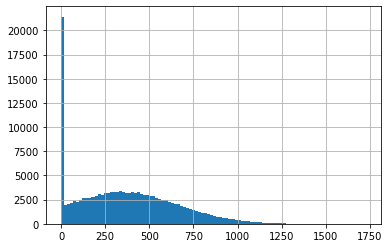

In [4]:
df_internet.info() # обзор структуры данных
print(df_internet.describe()) # обзор значений ячеек
df_internet['mb_used'].hist(bins=100)
plt.show()

Пропусков нет, но есть аномалия - много нулевых значений трафика. Вероятно, это неудачные сессии, которые могут исказить исследование, поэтому удалим их.  Также присутствует лишний столбец `Unnamed: 0`, в котором повторяются значения столбца `id`. Тип данных в столбце `session_date` - строковый, на этапе предобработки его нужно перевести в дату, а также удалить лишний столбец и нулевые значения трафика.

Изучим таблицу `df_messages`.

In [5]:
df_messages.info() # обзор структуры данных
df_messages.describe() # обзор значений ячеек

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


Пропусков нет, данные выглядят корректно. Тип данных в столбце `message_date` - строковый, на этапе предобработки его нужно перевести в дату.

В столбце `tariffs` мало данных, их не нужно рассматривать отдельно, так как мы убедились, что ошибок нет. Изучим данные в таблице `Users`.

In [6]:
df_users.info() # обзор структуры данных
df_users.describe() # обзор значений ячеек

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


Данные выглядят корректно, аномалий нет. Из описания следует, что пропуски в столбце `churn_date` (дата прекращения пользования тарифом) это не ошибка. Если значение пропущено, то тариф ещё действовал на момент выгрузки данных. Тип данных в столбцах `churn_date` `reg_date` - строковый, на этапе предобработки его нужно поменять на дату.

### Вывод

В данных нет пропусков, но найдена аномалия - множество нулевых значений трафика, которые нужно удалить в таблице `df_internet`. Поступим аналогичным способом с нулевой длительностью звонков в таблице `calls`.

В следующих таблицах нужно сделать перевод из строки в дату:

1. В `df_calls` столбец `call_date`.
2. В `df_internet` столбец `session_date`.
3. В `df_messages` столбец `message_date`.
4. В `df_users` столбцы `churn_date` и `reg_date`.

Также нужно будет удалить лишний столбец `Unnamed: 0` из таблицы `df_internet`.

## Предобработка данных

В первую очередь избавимся от нулевых значений трафика.

In [7]:
df_internet = df_internet.query('mb_used > 0') # удаление нулевых 
df_calls = df_calls.query('duration > 0') # значений через срез

Переведем строки в даты. И проверим результат на таблице `df_internet`.

In [8]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y.%m.%d') # перевод строк в формат даты
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y.%m.%d')   
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y.%m.%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y.%m.%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y.%m.%d')

df_internet = df_internet.drop(columns = ['Unnamed: 0'], axis=1) # удаление столбца
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            129798 non-null  object        
 1   mb_used       129798 non-null  float64       
 2   session_date  129798 non-null  datetime64[ns]
 3   user_id       129798 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.0+ MB


Тип данных отображается корректно, лишний столбец удален. Проверим наличие явных дубликатов в таблицах.

In [9]:
list_df = [df_calls, df_internet, df_messages, df_users] # список столбцов

for df in list_df: # цикл проверки на дубликаты
    print(df.duplicated().sum())

0
0
0
0


Дубликатов нет, на этом этап предобработки данных закончен.

## Подготовка данных

На этом этапе необходимо посчитать для каждого пользователя:
1. Количество сделанных звонков и израсходованных минут разговора по месяцам.
2. Количество отправленных сообщений по месяцам.
3. Объем израсходованного интернет-трафика по месяцам.
4. Помесячную выручку с каждого пользователя.

Добавим к таблицам столбец с месяцем.

In [10]:
df_calls['month'] = pd.DatetimeIndex(df_calls['call_date']).month # создание столбца с месяцем
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month

Перед тем, как группировать данные, округлим длительность до минут, согласно условиям тарифа.

In [11]:
df_calls['duration'] = np.ceil(df_calls['duration']) # округление до верхнего значения

Сгруппируем таблицы по каждому пользователю и посчитаем по месяцам количество звонков, минут, сообщений и трафик. После этого, округлим траффик за месяц до гигабайт, согласно условиям тарифа. В таблице `df_tariffs` переведем мегабайты в гигабайты для дальнейших расчетов.

In [12]:
df_calls_count = df_calls.groupby(['user_id', 'month'])['id'].count().reset_index() # группировка столбцов
df_calls_duration = df_calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()
df_messages_count = df_messages.groupby(['user_id', 'month'])['id'].count().reset_index()
df_internet_count = df_internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()

df_internet_count['mb_used'] = np.ceil(df_internet_count['mb_used'] / 1024) # округление до гигабайт
df_tariffs['mb_per_month_included'] = df_tariffs['mb_per_month_included'] / 1024

Последовательно объединим сгруппированые таблицы в одну общую и выведем промежуточную таблицу на экран, чтобы проверить результат.

In [13]:
df_1 = df_calls_count.merge(df_calls_duration, on=['user_id', 'month'], how='outer') # объединение таблиц
df_2 = df_1.merge(df_messages_count, on=['user_id', 'month'], how='outer')
df_3 = df_2.merge(df_internet_count, on=['user_id', 'month'], how='outer')
display(df_3.head())

,user_id,month,id_x,duration,id_y,mb_used
0,1000,5,17.0,159.0,22.0,3.0
1,1000,6,28.0,172.0,60.0,23.0
2,1000,7,41.0,340.0,75.0,14.0
3,1000,8,42.0,408.0,81.0,14.0
4,1000,9,46.0,466.0,57.0,15.0


Таблицы объединены корректно, но нужно переименовать столбцы `id_x`, `id_y` и `mb_used` на звонки, сообщения и интернет-траффик для дальнейших расчетов выручки. Объединим промежуточную таблицу с таблицой `df_users`. Также переименуем столбец с названием тарифа в таблице `df_users` для того, чтобы был общий столбец с таблицей `df_tariffs`. Объединим таблицы в общую и выведем результат на экран.

In [14]:
df_4 = df_3.merge(df_users, on=['user_id'], how='outer') # объединение таблиц

df_4 = df_4.rename(columns={ # переименование столбцов
    'id_x': 'calls', 'id_y': 'messages',
    'mb_used': 'gb_used', 'tariff': 'tariff_name',
})

df = df_4.merge(df_tariffs, on=['tariff_name'], how='outer').rename(columns={'mb_per_month_included': 'gb_per_month_included'})
display(df.head())

,user_id,month,calls,duration,messages,gb_used,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5.0,17.0,159.0,22.0,3.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
1,1000,6.0,28.0,172.0,60.0,23.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
2,1000,7.0,41.0,340.0,75.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
3,1000,8.0,42.0,408.0,81.0,14.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1
4,1000,9.0,46.0,466.0,57.0,15.0,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1


Посчитаем помесячную выручку для каждого клиента. Нам нужно вычесть бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика остаток умножить на значение из тарифного плана, прибавить абонентскую плату, соответствующую тарифному плану.

Напишем функцию, которая посчитает, есть ли расходы сверх пакетов звонков, смс и трафика. Если есть, то умножим эти значения на стоимость по тарифу. Сложим стоимость превышенных услуг с абонентской платой по тарифу. Запишем выручку в новый столбец `profit`.

In [15]:
def profit(row): # функция расчета выручки
    calls_cost = 0
    sms_cost = 0
    gb_cost = 0
    if (row['duration'] - row['minutes_included']) > 0:
        calls_cost = (row['duration'] - row['minutes_included']) * row['rub_per_minute']
    if (row['messages'] - row['messages_included']) > 0:
        sms_cost = (row['messages'] - row['messages_included']) * row['rub_per_message']
    if (row['gb_used'] - row['gb_per_month_included']) > 0:
        gb_cost = (row['gb_used'] - row['gb_per_month_included']) * row['rub_per_gb']
    result = calls_cost + sms_cost + gb_cost + row['rub_monthly_fee']
    return result
        
    
df['profit'] = df.apply(profit, axis=1) # применение функции и создание столбца с выручкой

display(df.head()) # вывод на экран

,user_id,month,calls,duration,messages,gb_used,age,churn_date,city,first_name,...,reg_date,tariff_name,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,profit
0,1000,5.0,17.0,159.0,22.0,3.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
1,1000,6.0,28.0,172.0,60.0,23.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
2,1000,7.0,41.0,340.0,75.0,14.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
3,1000,8.0,42.0,408.0,81.0,14.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0
4,1000,9.0,46.0,466.0,57.0,15.0,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,1000,30.0,3000,1950,150,1,1,1950.0


In [16]:
# Комментарий ревьюера
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3216 non-null   int64         
 1   month                  3214 non-null   float64       
 2   calls                  3168 non-null   float64       
 3   duration               3168 non-null   float64       
 4   messages               2717 non-null   float64       
 5   gb_used                3201 non-null   float64       
 6   age                    3216 non-null   int64         
 7   churn_date             189 non-null    datetime64[ns]
 8   city                   3216 non-null   object        
 9   first_name             3216 non-null   object        
 10  last_name              3216 non-null   object        
 11  reg_date               3216 non-null   datetime64[ns]
 12  tariff_name            3216 non-null   object        
 13  mes

Проверим пропущенные значения в столбцах и посчитаем процентное соотношение пропусков от всего датасета.

In [17]:
df.isna().sum() / len(df) * 100

user_id                   0.000000
month                     0.062189
calls                     1.492537
duration                  1.492537
messages                 15.516169
gb_used                   0.466418
age                       0.000000
churn_date               94.123134
city                      0.000000
first_name                0.000000
last_name                 0.000000
reg_date                  0.000000
tariff_name               0.000000
messages_included         0.000000
gb_per_month_included     0.000000
minutes_included          0.000000
rub_monthly_fee           0.000000
rub_per_gb                0.000000
rub_per_message           0.000000
rub_per_minute            0.000000
profit                    0.000000
dtype: float64

Больше всего пропупусков в столбце `churn_date`, но из описания следует, что пропуски  (дата прекращения пользования тарифом) это не ошибка. Если значение пропущено, то тариф ещё действовал на момент выгрузки данных. В столбцах `calls` и `duration` одинаковый процент пропусков, что говорит об отсутствии звоноков пользователя. Аналогичная ситуация с пропусками в столбце `messages` и `gb_used`. Заменим пропуски нулями. В столбце `month` пропущенных значений менее 1% от всего датасета, их можно удалить. Проверим результат.

In [18]:
df = df.dropna(subset=['month']) # удаление пропусков

list_nan = ['calls', 'duration', 'messages', 'gb_used'] # список столбцов
for col in list_nan: # цикл для замены пропусков нулями
    df[col] = df[col].fillna(0)
    
    
df.isna().sum() / len(df) * 100

user_id                   0.000000
month                     0.000000
calls                     0.000000
duration                  0.000000
messages                  0.000000
gb_used                   0.000000
age                       0.000000
churn_date               94.181705
city                      0.000000
first_name                0.000000
last_name                 0.000000
reg_date                  0.000000
tariff_name               0.000000
messages_included         0.000000
gb_per_month_included     0.000000
minutes_included          0.000000
rub_monthly_fee           0.000000
rub_per_gb                0.000000
rub_per_message           0.000000
rub_per_minute            0.000000
profit                    0.000000
dtype: float64

Мы собрали все необходимые данные в одну таблицу и провели расчеты. Теперь, когда данные подготовлены, можно приступать к исследованию.

## Анализ данных

На этом этапе необходимо описать поведение клиентов оператора, исходя из выборки. 

1. Нужно выяснить сколько требуется пользователям каждого тарифа в месяц:
    * минут разговора
    * сообщений
    * объём интернет-трафика
    
    
2. Посчитать:
    * среднее
    * стандартное отклонение
    * дисперсию
    
    
3. Построить гистограммы и описать распределения.

Разделим таблицу по тарифам. Сделаем сводные таблицы, посчитаем сколько минут, сообщений и трафика требуется пользователям каждого тарифа в месяц. Также рассчитаем среднее, стандартное отклонение и дисперсию. Выведем таблицы на экран.

In [19]:
smart = df.query('tariff_name == "smart"') # срез по 
ultra = df.query('tariff_name == "ultra"') # тарифам

df_pivot = df.pivot_table( # сводная таблица
    index='tariff_name',
    values=['duration', 'messages', 'gb_used'],
    aggfunc=['mean', np.std, np.var]
)

smart_pivot = smart.pivot_table( # сводная таблица с группировкой по месяцу
    index='month',
    values=['duration', 'messages', 'gb_used'],
    aggfunc=['mean', np.std, np.var]
)

ultra_pivot = ultra.pivot_table( # сводная таблица с группировкой по месяцу
    index='month',
    values=['duration', 'messages', 'gb_used'],
    aggfunc=['mean', np.std, np.var]
)

print('Сводная таблица')
display(df_pivot)
print()
print('Сводная таблица каждого месяца по услугам для тарифа Smart')
display(smart_pivot)
print()
print('Сводная таблица каждого месяца по услугам для тарифа Ultra')
display(ultra_pivot)

Сводная таблица


mean                               std            \
               duration    gb_used   messages    duration   gb_used   
tariff_name                                                           
smart        417.934948  16.328847  33.384029  190.313730  5.747061   
ultra        526.623350  19.494416  49.363452  317.606098  9.853511   

                                  var                          
              messages       duration    gb_used     messages  
tariff_name                                                    
smart        28.227876   36219.315784  33.028705   796.812958  
ultra        47.804457  100873.633397  97.091686  2285.266143


Сводная таблица каждого месяца по услугам для тарифа Smart


mean                               std                       \
         duration    gb_used   messages    duration   gb_used   messages   
month                                                                      
1.0    203.852941   8.735294  18.235294  154.231454  6.277950  16.197753   
2.0    298.689655  11.844828  24.086207  190.820041  6.095157  21.750809   
3.0    390.051948  15.233766  31.857143  191.893604  5.705252  26.804710   
4.0    367.133929  13.625000  30.741071  186.489161  5.594600  24.538532   
5.0    387.361702  15.907801  33.773050  186.601343  5.862594  27.036845   
6.0    395.640244  15.951220  33.402439  175.336587  5.649046  28.404337   
7.0    408.353234  15.875622  33.751244  179.583601  5.780956  28.282288   
8.0    421.468085  16.736170  33.638298  186.530382  5.480986  28.952677   
9.0    428.611538  16.392308  33.638462  183.126576  5.087643  28.117927   
10.0   426.136054  16.880952  33.765306  188.128510  5.735594  28.567673   
11.0   435.265823  17.000000  34.075949  177.778618  5.213535  28.389031   
12.0   478.560831  18.201780  35.994065  199.245131  5.457705  30.576990   

                var                         
           duration    gb_used    messages  
month                                       
1.0    23787.341355  39.412656  262.367201  
2.0    36412.287961  37.150938  473.097701  
3.0    36823.155161  32.549897  718.492481  
4.0    34778.207127  31.299550  602.139559  
5.0    34820.061094  34.370010  730.990983  
6.0    30742.918861  31.911716  806.806374  
7.0    32250.269602  33.419453  799.887811  
8.0    34793.583379  30.041207  838.257501  
9.0    33535.342723  25.884110  790.617820  
10.0   35392.336375  32.897042  816.111966  
11.0   31605.237050  27.180952  805.937071  
12.0   39698.622033  29.786544  934.952346


Сводная таблица каждого месяца по услугам для тарифа Ultra


mean                               std                        \
         duration    gb_used   messages    duration    gb_used   messages   
month                                                                       
1.0    428.111111  13.222222  33.777778  269.757968   6.666667  30.670742   
2.0    297.125000  12.000000  21.958333  296.512528  10.446551  26.773574   
3.0    489.648649  17.648649  32.297297  333.743765  10.693238  41.621886   
4.0    458.018182  16.963636  31.563636  267.682405   9.457436  37.513831   
5.0    510.328358  19.373134  37.850746  289.603511   9.779130  40.306874   
6.0    479.702381  18.940476  41.726190  302.549081   9.077114  44.567899   
7.0    545.791209  20.505495  49.846154  307.119322   9.819905  48.703621   
8.0    510.775701  19.598131  48.439252  312.980026  10.254184  46.601923   
9.0    539.443478  19.243478  52.286957  325.141162   9.287410  46.398874   
10.0   558.081301  20.065041  58.430894  326.289110   9.552907  51.934398   
11.0   541.380597  19.805970  55.791045  310.757232   9.684867  49.768951   
12.0   592.805755  21.741007  60.611511  342.456321  10.160550  51.787821   

                 var                           
            duration     gb_used     messages  
month                                          
1.0     72769.361111   44.444444   940.694444  
2.0     87919.679348  109.130435   716.824275  
3.0    111384.900901  114.345345  1732.381381  
4.0     71653.870034   89.443098  1407.287542  
5.0     83870.193578   95.631389  1624.644052  
6.0     91535.946500   82.394005  1986.297619  
7.0     94322.278144   96.430525  2372.042735  
8.0     97956.496385  105.148298  2171.739199  
9.0    105716.775286   86.255988  2152.855530  
10.0   106464.583500   91.258030  2697.181661  
11.0    96570.057064   93.796656  2476.948491  
12.0   117276.331561  103.236784  2681.978417

Таблица готова, можно строить гистограммы и столбчатые графикии для сравнения распределения по тарифам. Напишем функцию.

In [20]:
def hist_tariff(data_1, data_2, column, description, bins, a, b): # функция для построения графиков
    data_1[column].hist(bins=bins, range=(a, b), alpha=0.5, label='smart', figsize=(10, 5))
    data_2[column].hist(bins=bins, range=(a, b), alpha=0.5, label='ultra', figsize=(10, 5))
    plt.suptitle(description)
    plt.legend()
    plt.show()

Посмотрим распределение среднего количества потраченных минут по месяцам для двух тарифов.

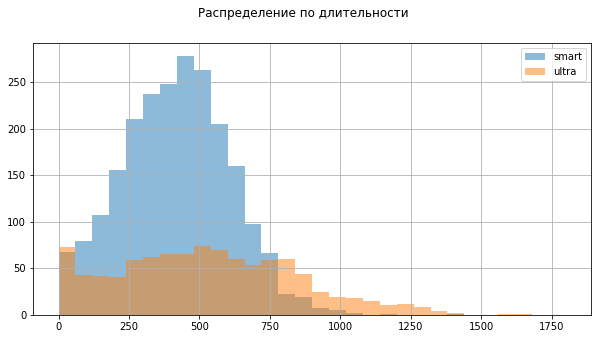

In [21]:
hist_tariff(smart, ultra, 'duration', 'Распределение по длительности', 30, 0, 1800)

Большинству пользователей тарифа Смарт требуется в месяц от 200 до 700 минут. Большинству пользователей тарифа Ультра требуется не более 800 минут. Можно сделать вывод, что третья часть пользователей тарифа Смарт регулярно превышает объем включенных в тариф минут.

Посмотрим распределение количества потраченных гигабайт интернет-трафика для двух тарифов.

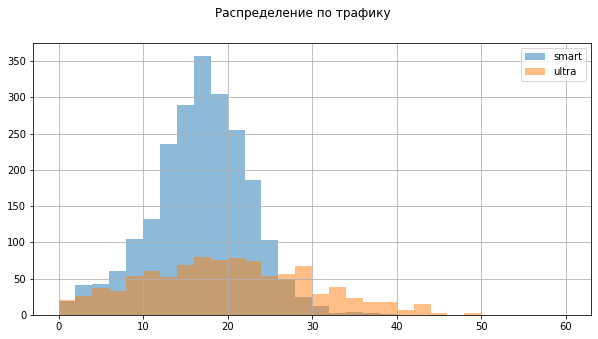

In [22]:
hist_tariff(smart, ultra, 'gb_used', 'Распределение по трафику', 30, 0, 60)

Большинству пользователей тарифа Смарт требуется в месяц от 10 до 25 гигабайт. Большинству пользователей тарифа Ультра требуется не более 30 гигабайт. Можно сделать вывод, что примерно половина пользователей тарифа Смарт регулярно превышает лимит трафика.

Посмотрим распределение количества отправленных сообщений по месяцам для двух тарифов.

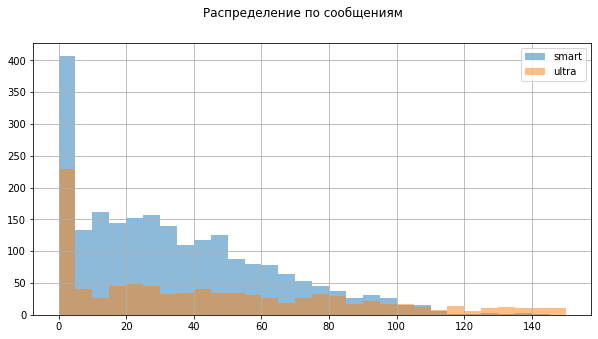

In [23]:
hist_tariff(smart, ultra, 'messages', 'Распределение по сообщениям', 30, 0, 150)

Большинству пользователей тарифа Смарт требуется в месяц не более 80 сообщений. Большинству пользователей тарифа Ультра требуется не более 100 сообщений. Можно сделать вывод, что примерно третья часть пользователей тарифа Смарт регулярно превышает лимит сообщений.

Теперь посчитаем среднюю выручку с каждого пользователя в зависимости от тарифа.

In [24]:
print(f'Количество пользователей тарифа Смарт: {smart["user_id"].count()}')
print(f'Количество пользователей тарифа Ультра: {ultra["user_id"].count()}')
print()

print(f'Средняя выручка с пользователя тарифа Смарт: {smart["profit"].mean()}')
print(f'Средняя выручка с пользователя тарифа Ультра: {ultra["profit"].mean()}')
print()

print(f'Годовая выручка с пользователей тарифа Смарт: {smart["profit"].sum()}')
print(f'Годовая выручка с пользователей тарифа Ультра: {ultra["profit"].sum()}')

Количество пользователей тарифа Смарт: 2229
Количество пользователей тарифа Ультра: 985

Средняя выручка с пользователя тарифа Смарт: 1289.9735307312696
Средняя выручка с пользователя тарифа Ультра: 2070.1522842639592

Годовая выручка с пользователей тарифа Смарт: 2875351.0
Годовая выручка с пользователей тарифа Ультра: 2039100.0


### Вывод

Пользователей тарифа Смарт в 2 раза больше чем пользователей тарифа Ультра. Пользователи тарифа Смарт принесли больше прибыли в год, чем тариф Ультра, но средняя выручка с каждого пользователя тарифа Ультра почти в 2 раза выше, чем с пользователя тарифа Смарт. 

Пользователи тарифа Смарт практически всегда полностью расходуют пакеты минут, сообщений и интернет-трафика. Есть тенденция превышения вкюченных пакетов, третья часть пользователей превышает лимит минут и сообщений, примерно половина превышает лимит трафика. 

Пользователи тарифа Ультра в среднем расходуют лимит минут на 20%, лимит сообщений на 5% и лимит трафика на 65%.

## Проверка гипотез

Теперь проверим следующие гипотезы с помощью статистического анализа:

1. Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
2. Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Проверим гипотезы с помощью t-test (статистический тест с использованием t-распределения Стьюдента), который позволяет сравнивать средние двух генеральных совокупностей между собой. В нулевой гипотезе мы предпологаем что средние равны. Пороговое значение alpha зададим 0.05.

### Гипотеза 1

H0 - Cредняя выручка пользователей тарифов Ультра и Смарт не различаются.

H1 - Средняя выручка пользователей тарифов Ультра и Смарт различаются.

In [25]:
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(smart['profit'], ultra['profit']) # t-test для двух совокупностей
print('p-значение: ', results.pvalue)

if results.pvalue < alpha: # условия для двух гипотез
    print('Отвергаем нулевую гипотезу о равенстве средних значений выручки')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве средних значений выручки')
    
print()
print('Средняя выручка для тарифа Смарт:', smart['profit'].mean())
print('Средняя выручка для тарифа Ультра:', ultra['profit'].mean())   

p-значение:  1.4229814360764067e-160
Отвергаем нулевую гипотезу о равенстве средних значений выручки

Средняя выручка для тарифа Смарт: 1289.9735307312696
Средняя выручка для тарифа Ультра: 2070.1522842639592


### Гипотеза 2

H0 - Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

H1 - Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [26]:
alpha = 0.05 # критический уровень статистической значимости

results = st.ttest_ind(df.query('city == "Москва"')['profit'], df.query('city != "Москва"')['profit']) # t-test для двух совокупностей
print('p-значение: ', results.pvalue)

if results.pvalue < alpha: # условия для двух гипотез
    print('Отвергаем нулевую гипотезу о равенстве средней выручки пользователей из Москвы и других регионов')
else:
    print('Не получилось отвергнуть нулевую гипотезу о равенстве средней выручки пользователей из Москвы и других регионов')
 
print()
print('Средняя выручка для Москвы:', df.query('city == "Москва"')['profit'].mean())
print('Средняя выручка для регионов:', df.query('city != "Москва"')['profit'].mean())

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу о равенстве средней выручки пользователей из Москвы и других регионов

Средняя выручка для Москвы: 1546.7135842880523
Средняя выручка для регионов: 1524.9362274298885


### Вывод

Мы проверили гипотезы с помощью t-test и можем сделать выводы:

1. Средняя выручка пользователей тарифов Ультра и Смарт различаются.
2. Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод

Задачей проекта было проанализировать поведение клиентов двух разных тарифов и и сделать вывод — какой из тарифов лучше.

Из нескольких таблиц сформировали общую и посчитали месячную выручку по каждому пользователю. С помощью графиков мы проанализировали поведение пользователей двух тарифов. С помощью статистического теста мы проверили гипотезу об отличии средней выручки для двух тарифов и гипотезу об отличии выручки между пользователями из Москвы и пользователями из других регионов. 

**Из исследования можно сделать вывод, что тариф Смарт приносит больше прибыли и лучше оптимизирован для нужд пользователей.**


Мы выяснили, что пользователей тарифа Смарт значительно больше, чем пользователей тарифа Ультра:

* для тарифа Смарт: 2230
* для тарифа Ультра: 986

Мы посчитали годовую выручку по тарифами:

* для тарифа Смарт: 2 875 901 руб.
* для тарифа Ультра: 2 041 050 руб.

Также мы посчитали среднюю выручку с каждого пользователя:

* для тарифа Смарт: 1290 руб.
* для тарифа Ультра: 2070 руб.

Пользователей тарифа Смарт в 2 раза больше чем пользователей тарифа Ультра. Пользователи тарифа Смарт принесли больше прибыли в год, чем тариф Ультра, но средняя выручка с каждого пользователя тарифа Ультра почти в 2 раза выше, чем с пользователя тарифа Смарт. 

Пользователи тарифа Смарт практически всегда полностью расходуют пакеты минут, сообщений и интернет-трафика. Есть тенденция превышения вкюченных пакетов, третья часть пользователей превышает лимит минут и сообщений, примерно половина превышает лимит трафика. 

Пользователи тарифа Ультра в среднем расходуют лимит минут на 20%, лимит сообщений на 5% и лимит трафика на 65%.

Мы проверили гипотезы с помощью t-test и можем сделать выводы:

1. Средняя выручка пользователей тарифов Ультра и Смарт различаются.
2. Cредняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

На графиках ниже отображена динамика средней прибыли по месяцам. Можно заметить, что на тарифе Смарт прибыль растет практически равномерно. На тарифе Ультра прибыль тоже растет, но наблюдются скачки, особенно резко выглядит падение прибыли с 7 по 9 месяц.

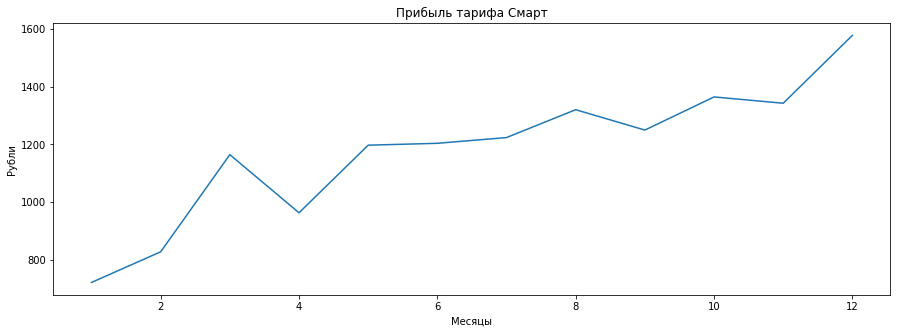

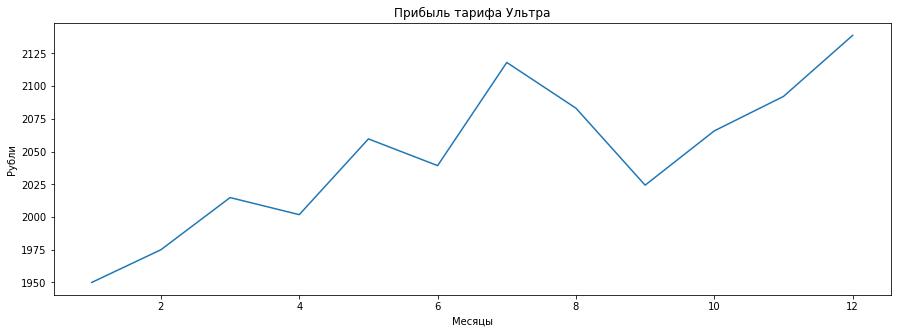

In [27]:
smart.pivot_table(
    index='month', values='profit', aggfunc='mean').plot(figsize=(15, 5),
    legend=False, title='Прибыль тарифа Смарт', xlabel='Месяцы', ylabel='Рубли')

ultra.pivot_table(
    index='month', values='profit', aggfunc='mean').plot(figsize=(15, 5),
    legend=False, title='Прибыль тарифа Ультра', xlabel='Месяцы', ylabel='Рубли')
plt.show()